# First run eda_customers!

In [1]:
# How many rows are there in tx?

import pandas as pd
tx = pd.read_csv("../data/processed/transactions_canonical.csv", dtype="string")
tx = tx.drop(columns=["invoiceEmail", "orderLineId"], errors="ignore")

In [2]:
print(len(tx))

299164


In [3]:
tx.dtypes


orderId       string[python]
shopUserId    string[python]
created       string[python]
currencyId    string[python]
sku           string[python]
groupId       string[python]
quantity      string[python]
price         string[python]
name          string[python]
type          string[python]
dtype: object

In [4]:
# Load articles
a = pd.read_csv("../data/processed/articles_clean.csv", dtype="string",
                usecols=["sku", "groupId"])
a = a.copy()
a["sku"] = a["sku"].str.strip()
tx_sku_stripped = tx["sku"].str.strip()

# Drop existing groupId column so merge adds exactly one copy
tx_no_groupid = tx.drop(columns=["groupId"], errors="ignore")

# Merge: now 'groupId' (single copy) comes from articles
tx_merged = tx_no_groupid.copy()
tx_merged["sku"] = tx_sku_stripped
tx_merged = tx_merged.merge(a, on="sku", how="left")

# Calculate unique skus and groupIds in tx and articles
tx_sku = pd.Index(tx_merged["sku"].dropna().unique())
a_sku = pd.Index(a["sku"].dropna().unique())
tx_groupid = pd.Index(tx_merged["groupId"].dropna().unique())
a_groupid = pd.Index(a["groupId"].dropna().unique())

# Calculate percentages
sku_pct = 100 * len(tx_sku.intersection(a_sku)) / len(a_sku) if len(a_sku) > 0 else float('nan')
groupid_pct = 100 * len(tx_groupid.intersection(a_groupid)) / len(a_groupid) if len(a_groupid) > 0 else float('nan')

print(f"Unique SKUs in tx: {len(tx_sku):,} | in articles: {len(a_sku):,}")
print(f"SKUs in tx as % of articles: {sku_pct:.2f}%")
print(f"Unique groupIds in tx: {len(tx_groupid):,} | in articles: {len(a_groupid):,}")
print(f"groupIds in tx as % of articles: {groupid_pct:.2f}%")

Unique SKUs in tx: 18,182 | in articles: 33,008
SKUs in tx as % of articles: 41.57%
Unique groupIds in tx: 1,410 | in articles: 1,742
groupIds in tx as % of articles: 80.94%


In [5]:
import pandas as pd

a_all = pd.read_csv(
    "../data/processed/articles_clean.csv",
    dtype={"sku": "string", "groupId": "string"},          # <-- don't set dtype for publishedDate
    usecols=["sku", "groupId", "publishedDate"]
)

# --- Parse dates robustly ---
a_all["publishedDate"] = pd.to_datetime(a_all["publishedDate"], errors="coerce", utc=True)

# UTC cutoff (pick your desired tz; keeping everything in UTC is simplest)
cutoff = pd.Timestamp("2024-06-01", tz="UTC")

# --- Normalize ids (strip; add .str.lower() if your IDs are case-insensitive) ---
for df, col in [(a_all, "sku"), (a_all, "groupId"), (tx, "sku"), (tx, "groupId")]:
    if col in df:
        df[col] = df[col].str.strip()

# --- Ensure tx has groupId from articles via SKU (skip if tx already has correct groupId) ---
if "groupId" in tx.columns:
    tx = tx.drop(columns=["groupId"])

tx = tx.merge(
    a_all[["sku", "groupId"]].dropna().drop_duplicates(),
    on="sku",
    how="left"
)

# --- Build sets and anti-join ---
before_ids = (
    a_all.loc[a_all["publishedDate"] < cutoff, ["groupId"]]
         .dropna()
         .drop_duplicates()
)

tx_ids = tx[["groupId"]].dropna().drop_duplicates()

never_bought = (
    before_ids.merge(tx_ids, on="groupId", how="left", indicator=True)
              .loc[lambda d: d["_merge"] == "left_only", "groupId"]
              .tolist()
)

print(never_bought)

# --- Optional: quick sanity check ---
print("Sanity check overlap:", pd.Series(never_bought).isin(tx_ids["groupId"]).sum())


['970100', '589084', '588970', '578745', '5620SF', '550178', '519292', '520077', '520075', '508031', '515273', '515071', '544405', '544397', '544396', '544395', '544393', '544388', '544387', '544379', '544803', '536213', '536212', '536211', '538028', '538061', '538057', '538054', '538053', '538049', '538037', '538036', '538035', '538034', '538026', '538022', '535069', '535631', '535693', '535117', '538492', '538259', '539118', '539116', '527713', '527747', '528033', '528032', '527002', '525011', '525206', '525188', '525205', '290138', '290284', '490079', '360140', '340578', '340569', '341174', '341171', '330907', '340997', '330906', '330901', '330419', '330412', '330253', '320356', '320355', '310426', '310612', '310609', '310606', '430028', '430222', '430027', '430013', '420357', '430494', '420312', '432035', '460072', '432063', '432060', '432059', '432046', '432044', '432040', '432037', '450005', '414100', '415040', '410315', '410314', '410055', '300499', '300233', '300105', '300594',

In [6]:
tx.dtypes

orderId       string[python]
shopUserId    string[python]
created       string[python]
currencyId    string[python]
sku           string[python]
quantity      string[python]
price         string[python]
name          string[python]
type          string[python]
groupId       string[python]
dtype: object

In [7]:
tx.isna().mean()

orderId       0.000000
shopUserId    0.000000
created       0.000000
currencyId    0.000000
sku           0.000003
quantity      0.000003
price         0.000003
name          0.000003
type          0.000000
groupId       0.280889
dtype: float64

## Remove known bugs

In [8]:
# Keep only rows where 'created' date is on or after 2024-06-01 to avoid migration bugs
tx['created'] = pd.to_datetime(tx['created'], errors='coerce')
tx = tx[tx['created'] >= pd.to_datetime('2024-06-01')]

In [9]:
print(len(tx))

295436


## Unify currenies to SEK for price bucketing

In [10]:
import pandas as pd

# Hardcoded mapping (use strings to match your dtypes)
currencyid_to_country = {
    "40":  "DK",  # Danish krone
    "134": "SE",  # Swedish krona
    "103": "NO",  # Norwegian krone
    "50":  "FI",  # Finland (EUR)
}

# FX to SEK (verify/update as needed)
conversion_rates = {
    "DK": 1.494795,  # DKK -> SEK
    "NO": 0.938825,  # NOK -> SEK
    "SE": 1.0,       # SEK -> SEK
    "FI": 11.1570,   # EUR -> SEK
}

# Normalize currencyId to strings and strip
tx["currencyId"] = tx["currencyId"].astype("string").str.strip()

# Map currencyId -> country code
tx["currency_country"] = tx["currencyId"].map(currencyid_to_country)

# Map country -> SEK rate
tx["sek_rate"] = tx["currency_country"].map(conversion_rates)

# Make sure price is numeric
tx["price"] = pd.to_numeric(tx["price"], errors="coerce")

# Compute price in SEK, round, and convert to integer (no .0)
tx["price_sek"] = (tx["price"] * tx["sek_rate"]).round(0).astype("Int64")

In [11]:
tx

,orderId,shopUserId,created,currencyId,sku,quantity,price,name,type,groupId,currency_country,sek_rate,price_sek
0,843561,887224,2025-09-17 14:42:48,134,240144-0040,1,498.0,Byxa,telephone,240144,SE,1.000000,498
1,843561,887224,2025-09-17 14:42:48,134,240144-0042,1,498.0,Byxa,telephone,240144,SE,1.000000,498
2,843561,887224,2025-09-17 14:42:48,134,260949-0006,1,208.0,Spetslinne 2-pack,telephone,260949,SE,1.000000,208
3,843560,887223,2025-09-17 14:39:41,103,261919-4345,2,79.0,Sokk med sklisikring og løs vrangbrod,telephone,261916,NO,0.938825,74
4,843560,887223,2025-09-17 14:39:41,103,240198-0046,1,249.0,Jeans med strikkmidje,telephone,240184,NO,0.938825,234
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295431,166428,252853,2024-06-01 05:23:25,40,261752-0050,1,299.0,Støttetrusse Jaquard&Lace,web,260345,DK,1.494795,447
295432,166428,252853,2024-06-01 05:23:25,40,261733-D110,1,599.0,BH uden bøjle Lovely Lace Support,web,239301,DK,1.494795,895
295433,166426,252851,2024-06-01 05:08:51,50,240189-0038,1,49.9,Kuviolliset housut,web,<NA>,FI,11.157000,557
295434,166420,252844,2024-06-01 00:58:50,103,263855-4135,1,469.0,Bh uten bøyle,web,263855,NO,0.938825,440


In [12]:
# Output rows where the price value is 6 digits or more
six_digit_price_rows = tx[tx['price'].astype(str).str.replace('.0$', '', regex=True).str.fullmatch(r'\d{6,}')]
six_digit_price_rows


,orderId,shopUserId,created,currencyId,sku,quantity,price,name,type,groupId,currency_country,sek_rate,price_sek
158466,545774,604121,2025-01-20 13:51:07,40,266825-C080,1,449399.0,BH uden bøjle Treasure,telephone,266825,DK,1.494795,671759


In [13]:
# Remove rows where the price value is 6 digits
tx = tx[~tx['price'].astype(str).str.replace('.0$', '', regex=True).str.fullmatch(r'\d{6}')]

Price (SEK) statistics (1st to 99th percentile):
  Count: 290,135
  Mean: 286.24
  Median: 234.00
  Std: 194.26
  Min (1st percentile): 18.00
  Max (99th percentile): 1,108.00


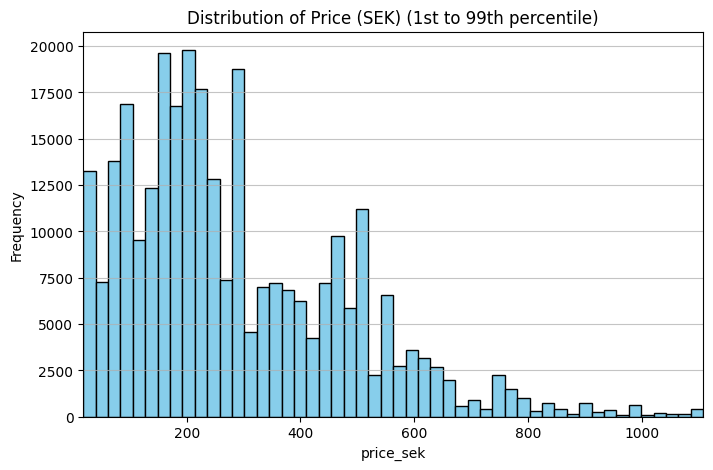

In [14]:
import matplotlib.pyplot as plt

# Show key statistics in numbers
price_sek = tx["price_sek"].dropna()
q_low = price_sek.quantile(0.01)
q_high = price_sek.quantile(0.99)
price_sek_trimmed = price_sek[(price_sek >= q_low) & (price_sek <= q_high)]

print("Price (SEK) statistics (1st to 99th percentile):")
print(f"  Count: {price_sek_trimmed.count():,}")
print(f"  Mean: {price_sek_trimmed.mean():,.2f}")
print(f"  Median: {price_sek_trimmed.median():,.2f}")
print(f"  Std: {price_sek_trimmed.std():,.2f}")
print(f"  Min (1st percentile): {q_low:,.2f}")
print(f"  Max (99th percentile): {q_high:,.2f}")

plt.figure(figsize=(8, 5))
plt.hist(
    price_sek_trimmed, 
    bins=50, 
    color="skyblue", 
    edgecolor="black"
)
plt.title("Distribution of Price (SEK) (1st to 99th percentile)")
plt.xlabel("price_sek")
plt.ylabel("Frequency")
plt.xlim(q_low, q_high)
plt.grid(axis='y', alpha=0.75)
plt.show()


In [15]:
# Read the cleaned customers data from CSV, ensuring 'shopUserId' is loaded as a string
customers = pd.read_csv("../data/processed/customers_clean.csv", dtype={"shopUserId": str})

# Merge the 'Age' column from the customers dataframe into the transactions dataframe, matching on 'shopUserId'
# This adds the 'Age' information for each transaction, using a left join to keep all transactions
tx = tx.merge(customers[["shopUserId", "Age"]], on="shopUserId", how="left")

In [16]:
tx.isna().mean()

orderId             0.000000
shopUserId          0.000000
created             0.000000
currencyId          0.000000
sku                 0.000003
quantity            0.000003
price               0.000003
name                0.000003
type                0.000000
groupId             0.279270
currency_country    0.000000
sek_rate            0.000000
price_sek           0.000003
Age                 0.365048
dtype: float64

# Line price

In [17]:
# Convert 'quantity' to numeric, round to nearest integer, and convert back to string (if needed)
tx["quantity"] = pd.to_numeric(tx["quantity"], errors="coerce").round().astype("Int64").astype(str)


In [18]:
print("Unique values of quantity:", tx["quantity"].unique())


Unique values of quantity: ['1' '2' '3' '4' '12' '5' '6' '8' '7' '11' '10' '9' '15' '16' '50' '176'
 '130' '19' '40' '20' '14' '229' '24' '18' '25' '999' '<NA>']


In [19]:
# Calculate line_total_sek as price_sek * quantity, ensuring both are numeric, rounded to nearest integer (no decimals), and drop rows where result is NA or 0
tx["price_sek"] = pd.to_numeric(tx["price_sek"], errors="coerce")
tx["quantity"] = pd.to_numeric(tx["quantity"], errors="coerce")
tx["line_total_sek"] = (tx["price_sek"] * tx["quantity"]).round()
# Ensure line_total_sek is numeric
tx["line_total_sek"] = pd.to_numeric(tx["line_total_sek"], errors="coerce")
# Drop rows where line_total_sek is NA or 0
tx = tx.dropna(subset=["line_total_sek"])
tx = tx[tx["line_total_sek"] != 0]


# Country remap COUNTRY_MAP_ALPHA = {"SE": "Sweden", "DK": "Denmark", "FI": "Finland", "NO": "Norway"}

In [20]:
COUNTRY_MAP_ALPHA = {"SE": "Sweden", "DK": "Denmark", "FI": "Finland", "NO": "Norway"}
tx["currency_country"] = tx["currency_country"].map(COUNTRY_MAP_ALPHA).fillna(tx["currency_country"])


In [21]:
# Save cleaned transactions to CSV with all columns as string
tx.astype(str).to_csv("../data/processed/transactions_clean.csv", index=False)

# Orders

In [49]:
import pandas as pd

# Merge invoiceCity and Gender from customers
customers = pd.read_csv("../data/processed/customers_clean.csv", dtype=str)
tx["shopUserId"] = tx["shopUserId"].astype(str)
customers["shopUserId"] = customers["shopUserId"].astype(str)
tx = tx.merge(customers[["shopUserId", "invoiceCity", "Gender"]], on="shopUserId", how="left")

# Merge category and brand from articles
articles = pd.read_csv("../data/processed/articles_clean.csv", dtype=str)
tx["groupId"] = tx["groupId"].astype(str)
cols = ["groupId"] + [col for col in ["category", "brand"] if col in articles.columns]
tx = tx.merge(articles[cols], on="groupId", how="left")

: 

In [ ]:
tx.dtypes

orderId             string[python]
shopUserId                  object
created             datetime64[ns]
currencyId          string[python]
sku                 string[python]
quantity                   float64
price                      Float64
name                string[python]
type                string[python]
groupId                     object
currency_country            object
sek_rate                   float64
price_sek                    Int64
Age                        float64
line_total_sek             Float64
invoiceCity                 object
Gender                      object
category                    object
brand                       object
dtype: object

In [25]:
tx.isna().mean()

orderId             0.000000
shopUserId          0.000000
created             0.000000
currencyId          0.000000
sku                 0.000000
quantity            0.000000
price               0.000000
name                0.000000
type                0.000000
groupId             0.000000
currency_country    0.000000
sek_rate            0.000000
price_sek           0.000000
Age                 0.416345
line_total_sek      0.000000
invoiceCity         0.057504
Gender              0.416345
category            0.008267
brand               0.008267
dtype: float64

In [26]:
import json, re
import numpy as np
import pandas as pd

# --- tiny helpers ---
def normalize_city(x):
    s = "Unknown" if x is None or (isinstance(x, float) and pd.isna(x)) else str(x)
    s = re.sub(r"\s+", " ", s).strip()
    s = re.sub(r"^(?:[A-Z]{1,3}[-\s])?\d{3,6}\s*", "", s, flags=re.IGNORECASE)  # drop leading ZIP
    s = re.sub(r"(?:,\s*)?(Denmark|Danmark|Sweden|Sverige|Norway|Norge|Finland|Suomi)\s*$", "", s, flags=re.IGNORECASE).strip()
    return s if s else "Unknown"

def status_from_orders(n):
    return "new" if n <= 1 else ("returning" if n <= 3 else "loyal")

def mode_or_first(s: pd.Series):
    m = s.mode()
    if not m.empty: 
        return m.iat[0]
    s = s.dropna()
    return s.iat[0] if not s.empty else None

# --- build a compact working frame from tx (only needed cols) ---
country = (
    tx["currency_country"].astype("string[python]").str.strip()
      .replace({"": pd.NA}).fillna("Unknown")
)
city = tx["invoiceCity"].map(normalize_city) if "invoiceCity" in tx.columns else pd.Series(["Unknown"]*len(tx))
shop = tx["shopUserId"].astype("string[python]").str.strip().replace({"": pd.NA})
order_id = tx["orderId"].astype("string[python]").str.strip()

created = tx["created"]
if not np.issubdtype(created.dtype, np.datetime64):
    created = pd.to_datetime(created, errors="coerce")

rev = pd.to_numeric(tx["line_total_sek"], errors="coerce").fillna(0)
typ = tx["type"] if "type" in tx.columns else pd.Series([None]*len(tx))

df = pd.DataFrame(
    {"country": country, "city": city, "shopUserId": shop, "orderId": order_id,
     "rev": rev, "created": created, "type": typ}
)

# --- country & city ---
agg_country = (
    df.groupby("country", dropna=False, sort=False)
      .agg(total_revenue_sek=("rev","sum"), customers_count=("shopUserId","nunique"))
)
agg_country["total_revenue_sek"] = np.rint(agg_country["total_revenue_sek"]).astype("int64")
agg_country["customers_count"] = agg_country["customers_count"].astype("int64")

agg_city = (
    df.groupby(["country","city"], dropna=False, sort=False)
      .agg(total_revenue_sek=("rev","sum"), customers_count=("shopUserId","nunique"))
)
agg_city["total_revenue_sek"] = np.rint(agg_city["total_revenue_sek"]).astype("int64")
agg_city["customers_count"] = agg_city["customers_count"].astype("int64")

# --- per-customer summary ---
df_cust = df[df["shopUserId"].notna()].copy()
agg_customer = (
    df_cust.groupby(["country","city","shopUserId"], dropna=False, sort=False)
      .agg(
          total_spent_sek=("rev","sum"),
          total_orders=("orderId","nunique"),
          first_order=("created","min"),
          last_order=("created","max"),
      )
)
agg_customer["total_spent_sek"] = np.rint(agg_customer["total_spent_sek"]).astype("int64")

# --- per-order (SMALL block only) ---
agg_order = (
    df_cust.groupby(["country","city","shopUserId","orderId"], dropna=False, sort=False)
      .agg(
          order_total_sek=("rev","sum"),
          n_items=("orderId","size"),
          created=("created","min"),
          order_type=("type", mode_or_first),
      )
)
agg_order["order_total_sek"] = np.rint(agg_order["order_total_sek"]).astype("int64")

# pack orders per customer for quick attach in Cell 2 (keeps memory small)
orders_by_customer = {}
for (ctry, cty, uid, oid), row in agg_order.iterrows():
    key = (ctry, cty, uid)
    orders_by_customer.setdefault(key, {})[str(oid)] = {
        "created": row["created"].isoformat(sep=" ") if pd.notna(row["created"]) else None,
        "order_total_sek": int(row["order_total_sek"]),
        "n_items": int(row["n_items"]),
        "order_type": row["order_type"] if (row["order_type"] is not np.nan) else None,
    }


In [27]:
# Build nested dict using only the aggregated frames from Cell 1
result = {}

# Countries
for ctry, row in agg_country.iterrows():
    result[ctry] = {
        "total_revenue_sek": int(row["total_revenue_sek"]),
        "customers_count": int(row["customers_count"]),
        "cities": {}
    }

# Cities
for (ctry, cty), row in agg_city.iterrows():
    result[ctry]["cities"][cty] = {
        "total_revenue_sek": int(row["total_revenue_sek"]),
        "customers_count": int(row["customers_count"]),
        "customers": {}
    }

# Customers + Orders
for (ctry, cty, uid), row in agg_customer.iterrows():
    status = status_from_orders(int(row["total_orders"]))
    first_iso = row["first_order"].isoformat(sep=" ") if pd.notna(row["first_order"]) else None
    last_iso  = row["last_order"].isoformat(sep=" ")  if pd.notna(row["last_order"])  else None

    result[ctry]["cities"][cty]["customers"][str(uid)] = {
        "summary": {
            "total_orders": int(row["total_orders"]),
            "total_spent_sek": int(row["total_spent_sek"]),
            "first_order": first_iso,
            "last_order": last_iso,
            "status": status,
        },
        "orders": orders_by_customer.get((ctry, cty, uid), {})  # attach packed orders
    }

# Save
out_path = "../data/processed/orders.json"
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(result, f, ensure_ascii=False, indent=2)

print("Saved:", out_path)


Saved: ../data/processed/orders.json


In [23]:
import pandas as pd
from decimal import Decimal, ROUND_HALF_UP

tx = tx.copy()

# --- 1) Tidy dtypes (concise) ---
str_cols = ["orderId", "shopUserId", "currencyId", "sku", "name", "groupId"]
tx[str_cols] = tx[str_cols].apply(lambda s: s.astype("string[python]").str.strip())

tx["created"]  = pd.to_datetime(tx["created"], errors="coerce")
tx["quantity"] = pd.to_numeric(tx["quantity"], errors="coerce").fillna(1).clip(lower=1).round().astype("Int64")
tx["price"]    = pd.to_numeric(tx["price"], errors="coerce").astype("Float64")
tx["sek_rate"] = pd.to_numeric(tx.get("sek_rate"), errors="coerce")  # float64

# Optional: price in SEK (two decimals). If you want integers, round later.
tx["price_sek"] = (tx["price"] * tx["sek_rate"]).round(2)

# Line total in SEK rounded to nearest krona (integer)
tx["_line_total"] = (tx["price_sek"] * tx["quantity"]).round().astype("Int64")

# --- 2) One row per orderId ---
orders = (
    tx.sort_values(["orderId", "created"])
      .groupby("orderId", as_index=False)
      .agg(
          shopUserId    = ("shopUserId", "first"),
          order_created = ("created", "min"),
          total_qty     = ("quantity", "sum"),
          basket_value  = ("_line_total", "sum"),
          currencyId    = ("currencyId", "first")
      )
)

# Ensure ints and compute avg unit price (integer)
orders["total_qty"]    = orders["total_qty"].astype(int)
orders["basket_value"] = orders["basket_value"].astype(int)
orders["avg_unit_price"] = (orders["basket_value"] / orders["total_qty"]).round().astype(int)

# --- 3) Lists per order (unique, sorted) ---
sku_list = (
    tx.groupby("orderId")["sku"]
      .apply(lambda s: sorted(pd.Series(s, dtype="string[python]").dropna().unique().tolist()))
      .rename("sku_list")
)
groupid_list = (
    tx.groupby("orderId")["groupId"]
      .apply(lambda s: sorted(pd.Series(s, dtype="string[python]").dropna().unique().tolist()))
      .rename("groupid_list")
)

orders = orders.merge(sku_list, on="orderId", how="left") \
               .merge(groupid_list, on="orderId", how="left")


In [24]:
# Number of orders
len(orders)


104858

In [25]:
orders.dtypes

orderId           string[python]
shopUserId        string[python]
order_created     datetime64[ns]
total_qty                  int64
basket_value               int64
currencyId        string[python]
avg_unit_price             int64
sku_list                  object
groupid_list              object
dtype: object

In [26]:
# Number of unique users
tx["shopUserId"].nunique()

60322

Users: 60322 | Sum of bins: 60322


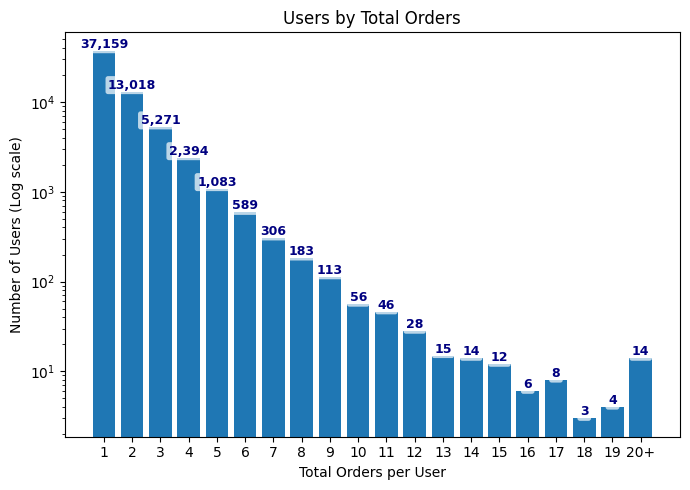

In [27]:
# total orders per user (one value per user)
n_orders_per_user = orders.groupby('shopUserId').size()

# bins: [1,2), [2,3), ..., [19,20), [20, inf)  -> label '20+' includes 20, 21, ...
bins   = list(range(1, 20)) + [20, float('inf')]
labels = [str(i) for i in range(1, 20)] + ['20+']

cats = pd.cut(n_orders_per_user, bins=bins, right=False, labels=labels, ordered=True)

# counts in the exact label order (no string sorting issues)
counts = cats.value_counts().reindex(labels, fill_value=0)

# sanity checks
assert counts.sum() == n_orders_per_user.size, "Counts should sum to #users"
print("Users:", n_orders_per_user.size, "| Sum of bins:", int(counts.sum()))

# plot
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
bars = plt.bar(labels, counts.values)
plt.yscale('log')  # optional; remember zeros won't show on log scale
plt.title('Users by Total Orders')
plt.xlabel('Total Orders per User')
plt.ylabel('Number of Users (Log scale)')

# annotate bars with more readable numbers (with thousands separator and horizontal orientation)
for i, v in enumerate(counts.values):
    if v > 0:
        plt.text(
            i, v, f'{int(v):,}', 
            ha='center', va='bottom', 
            rotation=0, fontsize=9, 
            fontweight='bold', color='navy',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2')
        )

plt.tight_layout()
plt.show()


“time to come back” (in days) between a user’s consecutive orders, buckets those gaps, and plots the distribution.

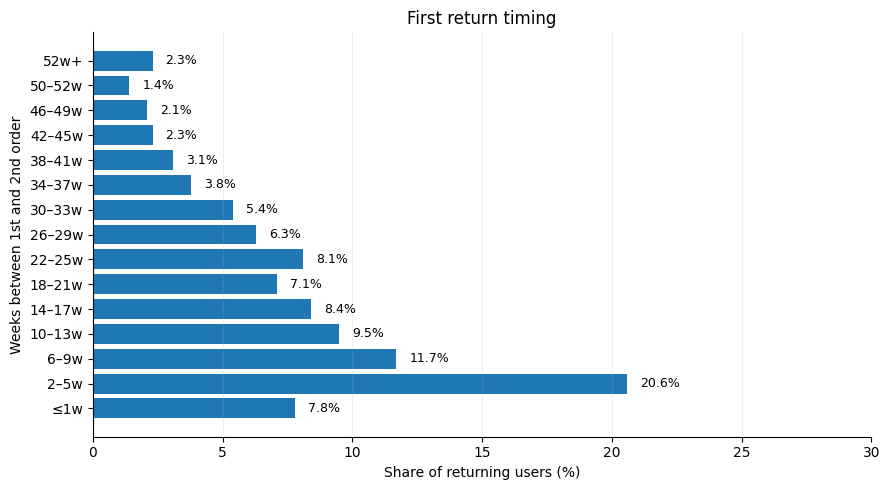

{'returning_users_denominator': 23163, 'rates_by_bucket_%': {'≤1w': 7.8, '2–5w': 20.6, '6–9w': 11.7, '10–13w': 9.5, '14–17w': 8.4, '18–21w': 7.1, '22–25w': 8.1, '26–29w': 6.3, '30–33w': 5.4, '34–37w': 3.8, '38–41w': 3.1, '42–45w': 2.3, '46–49w': 2.1, '50–52w': 1.4, '52w+': 2.3}, 'counts_by_bucket': {'≤1w': 1803, '2–5w': 4760, '6–9w': 2710, '10–13w': 2212, '14–17w': 1955, '18–21w': 1641, '22–25w': 1880, '26–29w': 1467, '30–33w': 1248, '34–37w': 881, '38–41w': 717, '42–45w': 537, '46–49w': 497, '50–52w': 323, '52w+': 532}}


In [28]:
# --- First return ONLY: weekly bins (≤1w, then 4-week bins) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

time_col = 'order_created'  # change if needed

# Prep & sort
orders[time_col] = pd.to_datetime(orders[time_col], errors='coerce', utc=True)
df = orders.dropna(subset=[time_col]).sort_values(['shopUserId', time_col]).copy()

# First return gaps (1st -> 2nd order), in WEEKS
df['next_time'] = df.groupby('shopUserId')[time_col].shift(-1)
df['gap_days']  = (df['next_time'] - df[time_col]).dt.total_seconds() / 86400.0
df['order_idx'] = df.groupby('shopUserId').cumcount()
first_ret = df.loc[df['order_idx'] == 0, ['shopUserId', 'gap_days']].dropna().copy()
first_ret = first_ret[first_ret['gap_days'] >= 0]
first_ret['gap_weeks'] = first_ret['gap_days'] / 7.0

# Bin edges in WEEKS: (0–1], (1–5], (5–9], ... up to 52, then inf
edges_w = [0, 1]
cur = 1
while cur < 52:
    cur += 4
    edges_w.append(min(cur, 52))
edges_w = sorted(set(edges_w))
if edges_w[-1] < 52:
    edges_w.append(52)
edges_w.append(np.inf)

# Labels aligned to right-closed intervals
labels = []
for a, b in zip(edges_w[:-1], edges_w[1:]):
    if np.isinf(b):
        labels.append('52w+')
    elif a == 0:
        labels.append('≤1w')
    else:
        labels.append(f'{int(a)+1}–{int(b)}w')

# Bucket (right=True → (a,b], include_lowest=True → [0,b] for first bin)
first_ret['bucket'] = pd.cut(
    first_ret['gap_weeks'],
    bins=edges_w, right=True,
    include_lowest=True,
    labels=labels, ordered=True
)

# Rates among returners (denominator = returning users only)
counts = first_ret['bucket'].value_counts().reindex(labels, fill_value=0)
total  = int(counts.sum())
rates  = (counts / total * 100).round(1) if total > 0 else counts.astype(float)

# Plot: horizontal bars (compact)
fig, ax = plt.subplots(figsize=(9,5))
ypos = np.arange(len(labels))
bars = ax.barh(labels, rates.values)

# Minimal, readable annotations (percent only)
for rect, pct in zip(bars, rates.values):
    ax.text(rect.get_width() + 0.5, rect.get_y() + rect.get_height()/2,
            f"{pct:.1f}%", va='center', ha='left', fontsize=9)

# Tidy aesthetics
ax.set_xlim(0, max(10, math.ceil((rates.max() if total>0 else 0) / 5.0) * 5 + 5))
ax.set_xlabel('Share of returning users (%)')
ax.set_ylabel('Weeks between 1st and 2nd order')
ax.set_title('First return timing')
ax.grid(axis='x', alpha=0.2)
for spine in ['top','right']:
    ax.spines[spine].set_visible(False)
plt.tight_layout()
plt.show()

print({
    "returning_users_denominator": total,
    "rates_by_bucket_%": rates.to_dict(),
    "counts_by_bucket": counts.to_dict()
})
